In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [2]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3
pose_w, pose_h, pose_d = 4,4,36

In [3]:
dataset = np.load('../../car_64.npy')


1553596416


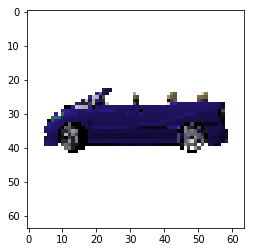

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset
dataset_train.nbytes

1242611712

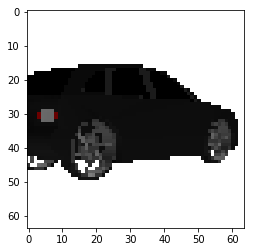

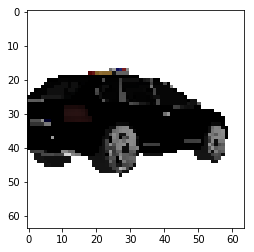

In [8]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [9]:
train_pairs = []
start_pose = [0]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 0, 1)
(1, 0, 1)
(529, 0, 8)
(163, 0, 20)


(2512, 0, 7)
(430, 0, 24)
98315


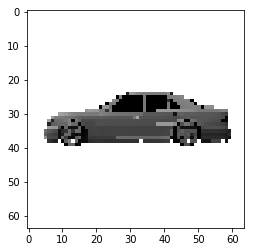

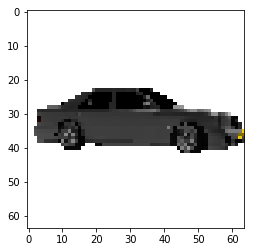

In [11]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(10*36) + 27]
j = dataset_train[(10*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [12]:
def normalize(data):
    data *= 2.0
    data /= 255.0
    data -= 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [13]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

35


In [14]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(pose_w, pose_h, pose_d)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
    pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3) (36, 4, 4, 36)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
<class 'numpy.float64'>
1.0 -1.0


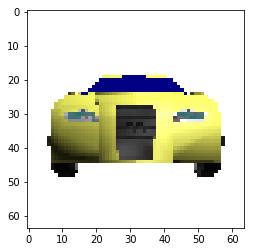

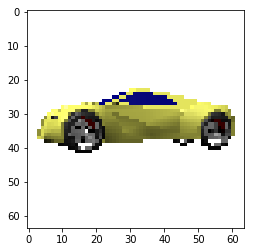

In [15]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 27
print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [16]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         #biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer())
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            #padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer(),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    return tf.reduce_mean(loss)

def local_moment_loss(pred, gt):
    with tf.name_scope('local_moment_loss'):

        ksz, kst = 4, 2
        local_patch = tf.ones((ksz, ksz, 1, 1))
        c = pred.get_shape()[-1]

        # Normalize by kernel size
        pr_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = (pr_var - tf.square(pr_mean)/(ksz**2)) / (ksz ** 2)
        pr_mean = pr_mean / (ksz ** 2)

        gt_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = (gt_var - tf.square(gt_mean)/(ksz**2)) / (ksz ** 2)
        gt_mean = gt_mean / (ksz ** 2)

        # scaling by local patch size
        local_mean_loss = tf.reduce_mean(tf.abs(pr_mean - gt_mean))
        local_var_loss = tf.reduce_mean(tf.abs(pr_var - gt_var))
    return local_mean_loss + local_var_loss
    

In [31]:
tf.reset_default_graph()

In [32]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, pose_w, pose_h, pose_d), name="pose")

In [33]:

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):

    with tf.variable_scope('encoder'):

        _ = conv2d(inputs_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        
        _ = batch_norm(_, True)
        _ = conv2d(_, output=48 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv4",act=lrelu)
        _ = tf.concat([pose_, _], 3)
       

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv1',act=lrelu)
        #_ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ 


In [34]:
global_step = tf.Variable(0,trainable=False)
lr = 1e-3

In [35]:
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(lr, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
res = auto_encoder(inputs_, pose_)
loss_op = l1_loss(res, targets_)

gradients, variables = zip(*optimizer.compute_gradients(loss_op))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
train_op = optimizer.apply_gradients(zip(gradients, variables))


O1 (36, 64, 64, 3)


Epoch: 1/20... Training loss: 0.1796
Epoch: 1/20... Training loss: 0.1471
Epoch: 1/20... Training loss: 0.1496
Epoch: 1/20... Training loss: 0.1746
Epoch: 1/20... Training loss: 0.1284
Epoch: 1/20... Training loss: 0.1285
Epoch: 1/20... Training loss: 0.1254
Epoch: 1/20... Training loss: 0.1126
Epoch: 1/20... Training loss: 0.1227
Epoch: 1/20... Training loss: 0.1236
Epoch: 1/20... Training loss: 0.1159
Epoch: 1/20... Training loss: 0.1100
Epoch: 1/20... Training loss: 0.1171
Epoch: 1/20... Training loss: 0.1115
Epoch: 1/20... Training loss: 0.1246
Epoch: 1/20... Training loss: 0.1208
Epoch: 1/20... Training loss: 0.1139
Epoch: 1/20... Training loss: 0.1130
Epoch: 1/20... Training loss: 0.1127
Epoch: 1/20... Training loss: 0.1039
Epoch: 1/20... Training loss: 0.1050
Epoch: 1/20... Training loss: 0.1017
Epoch: 1/20... Training loss: 0.0907
Epoch: 1/20... Training loss: 0.1058
Epoch: 1/20... Training loss: 0.1093
Epoch: 1/20... Training loss: 0.1087
Epoch: 1/20... Training loss: 0.1106


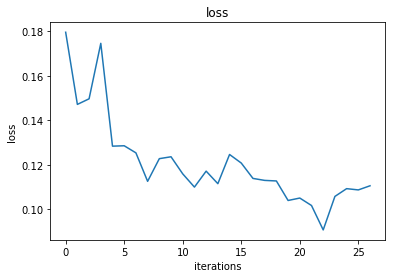

Epoch: 2/20... Training loss: 0.1000
Epoch: 2/20... Training loss: 0.0888
Epoch: 2/20... Training loss: 0.1056
Epoch: 2/20... Training loss: 0.1019
Epoch: 2/20... Training loss: 0.1131
Epoch: 2/20... Training loss: 0.1054
Epoch: 2/20... Training loss: 0.1101
Epoch: 2/20... Training loss: 0.1015
Epoch: 2/20... Training loss: 0.1074
Epoch: 2/20... Training loss: 0.1072
Epoch: 2/20... Training loss: 0.1003
Epoch: 2/20... Training loss: 0.1049
Epoch: 2/20... Training loss: 0.1034
Epoch: 2/20... Training loss: 0.1117
Epoch: 2/20... Training loss: 0.1115
Epoch: 2/20... Training loss: 0.1062
Epoch: 2/20... Training loss: 0.0918
Epoch: 2/20... Training loss: 0.0963
Epoch: 2/20... Training loss: 0.1032
Epoch: 2/20... Training loss: 0.0970
Epoch: 2/20... Training loss: 0.1044
Epoch: 2/20... Training loss: 0.1068
Epoch: 2/20... Training loss: 0.0940
Epoch: 2/20... Training loss: 0.0968
Epoch: 2/20... Training loss: 0.1005
Epoch: 2/20... Training loss: 0.0910
Epoch: 2/20... Training loss: 0.0961


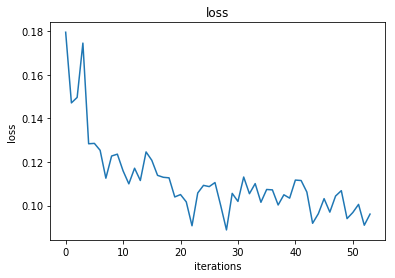

Epoch: 3/20... Training loss: 0.0938
Epoch: 3/20... Training loss: 0.0927
Epoch: 3/20... Training loss: 0.0960
Epoch: 3/20... Training loss: 0.1024
Epoch: 3/20... Training loss: 0.0844
Epoch: 3/20... Training loss: 0.0908
Epoch: 3/20... Training loss: 0.0949
Epoch: 3/20... Training loss: 0.0924
Epoch: 3/20... Training loss: 0.0994
Epoch: 3/20... Training loss: 0.0966
Epoch: 3/20... Training loss: 0.0978
Epoch: 3/20... Training loss: 0.0920
Epoch: 3/20... Training loss: 0.0859
Epoch: 3/20... Training loss: 0.0895
Epoch: 3/20... Training loss: 0.0857
Epoch: 3/20... Training loss: 0.0995
Epoch: 3/20... Training loss: 0.0827
Epoch: 3/20... Training loss: 0.0932
Epoch: 3/20... Training loss: 0.0926
Epoch: 3/20... Training loss: 0.0907
Epoch: 3/20... Training loss: 0.0949
Epoch: 3/20... Training loss: 0.1013
Epoch: 3/20... Training loss: 0.0991
Epoch: 3/20... Training loss: 0.0944
Epoch: 3/20... Training loss: 0.0904
Epoch: 3/20... Training loss: 0.0884
Epoch: 3/20... Training loss: 0.0889


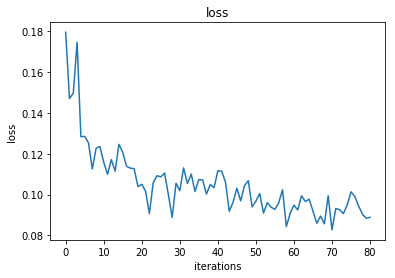

Epoch: 4/20... Training loss: 0.0917
Epoch: 4/20... Training loss: 0.0997
Epoch: 4/20... Training loss: 0.0787
Epoch: 4/20... Training loss: 0.0912
Epoch: 4/20... Training loss: 0.0862
Epoch: 4/20... Training loss: 0.1003
Epoch: 4/20... Training loss: 0.0875
Epoch: 4/20... Training loss: 0.0984
Epoch: 4/20... Training loss: 0.0864
Epoch: 4/20... Training loss: 0.0870
Epoch: 4/20... Training loss: 0.0868
Epoch: 4/20... Training loss: 0.0879
Epoch: 4/20... Training loss: 0.0883
Epoch: 4/20... Training loss: 0.0728
Epoch: 4/20... Training loss: 0.0929
Epoch: 4/20... Training loss: 0.0851
Epoch: 4/20... Training loss: 0.0884
Epoch: 4/20... Training loss: 0.0759
Epoch: 4/20... Training loss: 0.0844
Epoch: 4/20... Training loss: 0.0978
Epoch: 4/20... Training loss: 0.0849
Epoch: 4/20... Training loss: 0.0848
Epoch: 4/20... Training loss: 0.0947
Epoch: 4/20... Training loss: 0.0808
Epoch: 4/20... Training loss: 0.0867
Epoch: 4/20... Training loss: 0.0894
Epoch: 4/20... Training loss: 0.1051
E

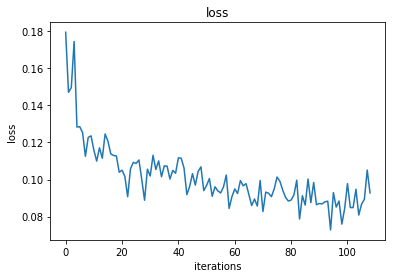

Epoch: 5/20... Training loss: 0.0872
Epoch: 5/20... Training loss: 0.0950
Epoch: 5/20... Training loss: 0.0829
Epoch: 5/20... Training loss: 0.0852
Epoch: 5/20... Training loss: 0.0852
Epoch: 5/20... Training loss: 0.0852
Epoch: 5/20... Training loss: 0.0789
Epoch: 5/20... Training loss: 0.0806
Epoch: 5/20... Training loss: 0.0809
Epoch: 5/20... Training loss: 0.0820
Epoch: 5/20... Training loss: 0.0863
Epoch: 5/20... Training loss: 0.0806
Epoch: 5/20... Training loss: 0.0865
Epoch: 5/20... Training loss: 0.0837
Epoch: 5/20... Training loss: 0.0814
Epoch: 5/20... Training loss: 0.0856
Epoch: 5/20... Training loss: 0.0977
Epoch: 5/20... Training loss: 0.0866
Epoch: 5/20... Training loss: 0.0834
Epoch: 5/20... Training loss: 0.0743
Epoch: 5/20... Training loss: 0.0928
Epoch: 5/20... Training loss: 0.0890
Epoch: 5/20... Training loss: 0.0869
Epoch: 5/20... Training loss: 0.0849
Epoch: 5/20... Training loss: 0.0796
Epoch: 5/20... Training loss: 0.0779
Epoch: 5/20... Training loss: 0.0797


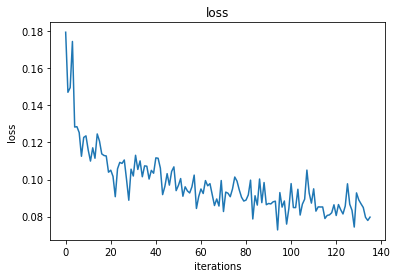

Epoch: 6/20... Training loss: 0.0904
Epoch: 6/20... Training loss: 0.0793
Epoch: 6/20... Training loss: 0.0880
Epoch: 6/20... Training loss: 0.0862
Epoch: 6/20... Training loss: 0.0836
Epoch: 6/20... Training loss: 0.0797
Epoch: 6/20... Training loss: 0.0829
Epoch: 6/20... Training loss: 0.0788
Epoch: 6/20... Training loss: 0.0934
Epoch: 6/20... Training loss: 0.0839
Epoch: 6/20... Training loss: 0.0919
Epoch: 6/20... Training loss: 0.0842
Epoch: 6/20... Training loss: 0.0951
Epoch: 6/20... Training loss: 0.0785
Epoch: 6/20... Training loss: 0.0767
Epoch: 6/20... Training loss: 0.0883
Epoch: 6/20... Training loss: 0.0910
Epoch: 6/20... Training loss: 0.0809
Epoch: 6/20... Training loss: 0.0843
Epoch: 6/20... Training loss: 0.0807
Epoch: 6/20... Training loss: 0.0855
Epoch: 6/20... Training loss: 0.0832
Epoch: 6/20... Training loss: 0.0926
Epoch: 6/20... Training loss: 0.0775
Epoch: 6/20... Training loss: 0.0900
Epoch: 6/20... Training loss: 0.0752
Epoch: 6/20... Training loss: 0.0815


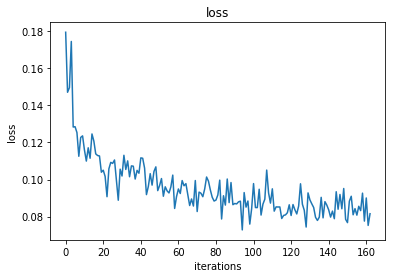

Epoch: 7/20... Training loss: 0.0756
Epoch: 7/20... Training loss: 0.0783
Epoch: 7/20... Training loss: 0.0865
Epoch: 7/20... Training loss: 0.0845
Epoch: 7/20... Training loss: 0.0767
Epoch: 7/20... Training loss: 0.0993
Epoch: 7/20... Training loss: 0.0792
Epoch: 7/20... Training loss: 0.0785
Epoch: 7/20... Training loss: 0.0762
Epoch: 7/20... Training loss: 0.0775
Epoch: 7/20... Training loss: 0.0794
Epoch: 7/20... Training loss: 0.0933
Epoch: 7/20... Training loss: 0.0727
Epoch: 7/20... Training loss: 0.0865
Epoch: 7/20... Training loss: 0.0810
Epoch: 7/20... Training loss: 0.0849
Epoch: 7/20... Training loss: 0.0831
Epoch: 7/20... Training loss: 0.0892
Epoch: 7/20... Training loss: 0.0837
Epoch: 7/20... Training loss: 0.0848
Epoch: 7/20... Training loss: 0.0987
Epoch: 7/20... Training loss: 0.0789
Epoch: 7/20... Training loss: 0.0834
Epoch: 7/20... Training loss: 0.0855
Epoch: 7/20... Training loss: 0.0854
Epoch: 7/20... Training loss: 0.0740
Epoch: 7/20... Training loss: 0.0795
E

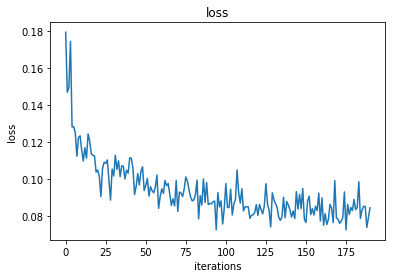

Epoch: 8/20... Training loss: 0.0785
Epoch: 8/20... Training loss: 0.0911
Epoch: 8/20... Training loss: 0.0820
Epoch: 8/20... Training loss: 0.0869
Epoch: 8/20... Training loss: 0.0937
Epoch: 8/20... Training loss: 0.0917
Epoch: 8/20... Training loss: 0.0867
Epoch: 8/20... Training loss: 0.0722
Epoch: 8/20... Training loss: 0.0810
Epoch: 8/20... Training loss: 0.0831
Epoch: 8/20... Training loss: 0.0743
Epoch: 8/20... Training loss: 0.0859
Epoch: 8/20... Training loss: 0.0794
Epoch: 8/20... Training loss: 0.0801
Epoch: 8/20... Training loss: 0.0835
Epoch: 8/20... Training loss: 0.0799
Epoch: 8/20... Training loss: 0.0726
Epoch: 8/20... Training loss: 0.0796
Epoch: 8/20... Training loss: 0.0858
Epoch: 8/20... Training loss: 0.0757
Epoch: 8/20... Training loss: 0.0790
Epoch: 8/20... Training loss: 0.0704
Epoch: 8/20... Training loss: 0.0782
Epoch: 8/20... Training loss: 0.0807
Epoch: 8/20... Training loss: 0.0786
Epoch: 8/20... Training loss: 0.0783
Epoch: 8/20... Training loss: 0.0771


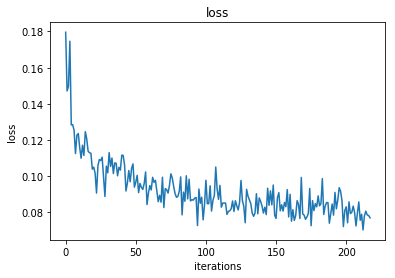

Epoch: 9/20... Training loss: 0.0789
Epoch: 9/20... Training loss: 0.0761
Epoch: 9/20... Training loss: 0.0917
Epoch: 9/20... Training loss: 0.0836
Epoch: 9/20... Training loss: 0.0754
Epoch: 9/20... Training loss: 0.0857
Epoch: 9/20... Training loss: 0.0786
Epoch: 9/20... Training loss: 0.0816
Epoch: 9/20... Training loss: 0.0795
Epoch: 9/20... Training loss: 0.0753
Epoch: 9/20... Training loss: 0.0841
Epoch: 9/20... Training loss: 0.0797
Epoch: 9/20... Training loss: 0.0852
Epoch: 9/20... Training loss: 0.0811
Epoch: 9/20... Training loss: 0.0896
Epoch: 9/20... Training loss: 0.0881
Epoch: 9/20... Training loss: 0.0776
Epoch: 9/20... Training loss: 0.0758
Epoch: 9/20... Training loss: 0.0946
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0821
Epoch: 9/20... Training loss: 0.0756
Epoch: 9/20... Training loss: 0.0813
Epoch: 9/20... Training loss: 0.0796
Epoch: 9/20... Training loss: 0.0779
Epoch: 9/20... Training loss: 0.0784
Epoch: 9/20... Training loss: 0.0903


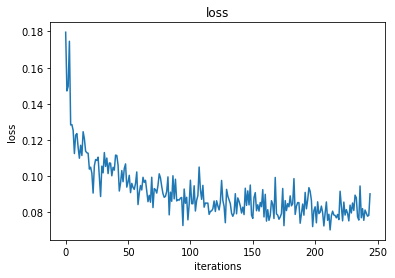

Epoch: 10/20... Training loss: 0.0706
Epoch: 10/20... Training loss: 0.0806
Epoch: 10/20... Training loss: 0.0860
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0780
Epoch: 10/20... Training loss: 0.0783
Epoch: 10/20... Training loss: 0.0791
Epoch: 10/20... Training loss: 0.0744
Epoch: 10/20... Training loss: 0.0782
Epoch: 10/20... Training loss: 0.0800
Epoch: 10/20... Training loss: 0.0787
Epoch: 10/20... Training loss: 0.0710
Epoch: 10/20... Training loss: 0.0777
Epoch: 10/20... Training loss: 0.1004
Epoch: 10/20... Training loss: 0.0726
Epoch: 10/20... Training loss: 0.0756
Epoch: 10/20... Training loss: 0.0698
Epoch: 10/20... Training loss: 0.0740
Epoch: 10/20... Training loss: 0.0859
Epoch: 10/20... Training loss: 0.0798
Epoch: 10/20... Training loss: 0.0839
Epoch: 10/20... Training loss: 0.0896
Epoch: 10/20... Training loss: 0.0876
Epoch: 10/20... Training loss: 0.0739
Epoch: 10/20... Training loss: 0.0851
Epoch: 10/20... Training loss: 0.0767
Epoch: 10/20

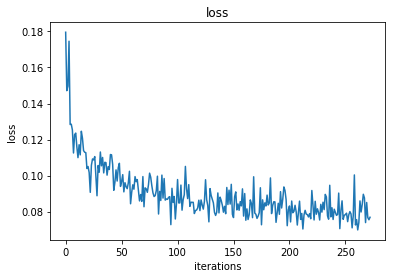

Epoch: 11/20... Training loss: 0.0772
Epoch: 11/20... Training loss: 0.0678
Epoch: 11/20... Training loss: 0.0718
Epoch: 11/20... Training loss: 0.0929
Epoch: 11/20... Training loss: 0.0712
Epoch: 11/20... Training loss: 0.0735
Epoch: 11/20... Training loss: 0.0792
Epoch: 11/20... Training loss: 0.0741
Epoch: 11/20... Training loss: 0.0813
Epoch: 11/20... Training loss: 0.0850
Epoch: 11/20... Training loss: 0.0778
Epoch: 11/20... Training loss: 0.0794
Epoch: 11/20... Training loss: 0.0807
Epoch: 11/20... Training loss: 0.0782
Epoch: 11/20... Training loss: 0.0876
Epoch: 11/20... Training loss: 0.0868
Epoch: 11/20... Training loss: 0.0821
Epoch: 11/20... Training loss: 0.0802
Epoch: 11/20... Training loss: 0.0770
Epoch: 11/20... Training loss: 0.0764
Epoch: 11/20... Training loss: 0.0713
Epoch: 11/20... Training loss: 0.0715
Epoch: 11/20... Training loss: 0.0703
Epoch: 11/20... Training loss: 0.0792
Epoch: 11/20... Training loss: 0.0789
Epoch: 11/20... Training loss: 0.0812
Epoch: 11/20

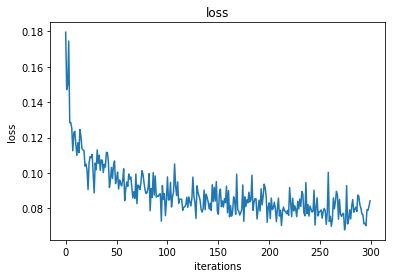

Epoch: 12/20... Training loss: 0.0720
Epoch: 12/20... Training loss: 0.0672
Epoch: 12/20... Training loss: 0.0745
Epoch: 12/20... Training loss: 0.0761
Epoch: 12/20... Training loss: 0.0837
Epoch: 12/20... Training loss: 0.0792
Epoch: 12/20... Training loss: 0.0775
Epoch: 12/20... Training loss: 0.0677
Epoch: 12/20... Training loss: 0.0801
Epoch: 12/20... Training loss: 0.0812
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0810
Epoch: 12/20... Training loss: 0.0724
Epoch: 12/20... Training loss: 0.0854
Epoch: 12/20... Training loss: 0.0822
Epoch: 12/20... Training loss: 0.0791
Epoch: 12/20... Training loss: 0.0688
Epoch: 12/20... Training loss: 0.0729
Epoch: 12/20... Training loss: 0.0772
Epoch: 12/20... Training loss: 0.0786
Epoch: 12/20... Training loss: 0.0831
Epoch: 12/20... Training loss: 0.0839
Epoch: 12/20... Training loss: 0.0770
Epoch: 12/20... Training loss: 0.0783
Epoch: 12/20... Training loss: 0.0748
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20

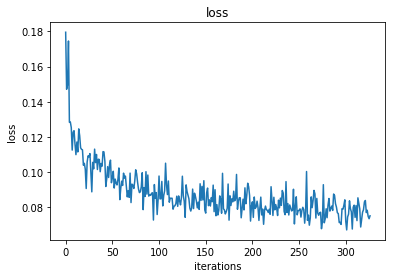

Epoch: 13/20... Training loss: 0.0786
Epoch: 13/20... Training loss: 0.0752
Epoch: 13/20... Training loss: 0.0790
Epoch: 13/20... Training loss: 0.0858
Epoch: 13/20... Training loss: 0.0678
Epoch: 13/20... Training loss: 0.0762
Epoch: 13/20... Training loss: 0.0788
Epoch: 13/20... Training loss: 0.0729
Epoch: 13/20... Training loss: 0.0797
Epoch: 13/20... Training loss: 0.0800
Epoch: 13/20... Training loss: 0.0801
Epoch: 13/20... Training loss: 0.0766
Epoch: 13/20... Training loss: 0.0748
Epoch: 13/20... Training loss: 0.0738
Epoch: 13/20... Training loss: 0.0727
Epoch: 13/20... Training loss: 0.0832
Epoch: 13/20... Training loss: 0.0692
Epoch: 13/20... Training loss: 0.0754
Epoch: 13/20... Training loss: 0.0786
Epoch: 13/20... Training loss: 0.0754
Epoch: 13/20... Training loss: 0.0793
Epoch: 13/20... Training loss: 0.0864
Epoch: 13/20... Training loss: 0.0832
Epoch: 13/20... Training loss: 0.0801
Epoch: 13/20... Training loss: 0.0771
Epoch: 13/20... Training loss: 0.0771
Epoch: 13/20

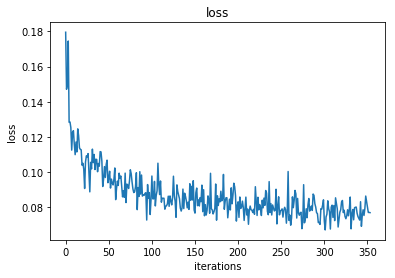

Epoch: 14/20... Training loss: 0.0782
Epoch: 14/20... Training loss: 0.0850
Epoch: 14/20... Training loss: 0.0672
Epoch: 14/20... Training loss: 0.0776
Epoch: 14/20... Training loss: 0.0743
Epoch: 14/20... Training loss: 0.0828
Epoch: 14/20... Training loss: 0.0750
Epoch: 14/20... Training loss: 0.0858
Epoch: 14/20... Training loss: 0.0746
Epoch: 14/20... Training loss: 0.0769
Epoch: 14/20... Training loss: 0.0753
Epoch: 14/20... Training loss: 0.0773
Epoch: 14/20... Training loss: 0.0767
Epoch: 14/20... Training loss: 0.0629
Epoch: 14/20... Training loss: 0.0834
Epoch: 14/20... Training loss: 0.0741
Epoch: 14/20... Training loss: 0.0773
Epoch: 14/20... Training loss: 0.0678
Epoch: 14/20... Training loss: 0.0726
Epoch: 14/20... Training loss: 0.0845
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0748
Epoch: 14/20... Training loss: 0.0839
Epoch: 14/20... Training loss: 0.0710
Epoch: 14/20... Training loss: 0.0783
Epoch: 14/20... Training loss: 0.0793
Epoch: 14/20

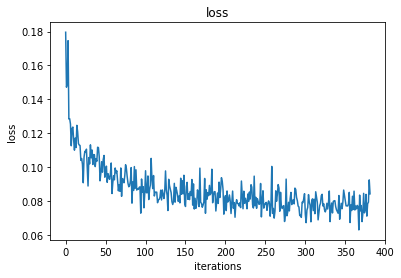

Epoch: 15/20... Training loss: 0.0758
Epoch: 15/20... Training loss: 0.0835
Epoch: 15/20... Training loss: 0.0732
Epoch: 15/20... Training loss: 0.0750
Epoch: 15/20... Training loss: 0.0767
Epoch: 15/20... Training loss: 0.0750
Epoch: 15/20... Training loss: 0.0680
Epoch: 15/20... Training loss: 0.0726
Epoch: 15/20... Training loss: 0.0727
Epoch: 15/20... Training loss: 0.0713
Epoch: 15/20... Training loss: 0.0800
Epoch: 15/20... Training loss: 0.0708
Epoch: 15/20... Training loss: 0.0789
Epoch: 15/20... Training loss: 0.0716
Epoch: 15/20... Training loss: 0.0746
Epoch: 15/20... Training loss: 0.0768
Epoch: 15/20... Training loss: 0.0863
Epoch: 15/20... Training loss: 0.0761
Epoch: 15/20... Training loss: 0.0743
Epoch: 15/20... Training loss: 0.0675
Epoch: 15/20... Training loss: 0.0826
Epoch: 15/20... Training loss: 0.0796
Epoch: 15/20... Training loss: 0.0768
Epoch: 15/20... Training loss: 0.0767
Epoch: 15/20... Training loss: 0.0716
Epoch: 15/20... Training loss: 0.0730
Epoch: 15/20

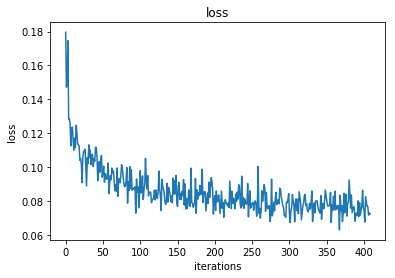

Epoch: 16/20... Training loss: 0.0811
Epoch: 16/20... Training loss: 0.0715
Epoch: 16/20... Training loss: 0.0796
Epoch: 16/20... Training loss: 0.0785
Epoch: 16/20... Training loss: 0.0758
Epoch: 16/20... Training loss: 0.0741
Epoch: 16/20... Training loss: 0.0741
Epoch: 16/20... Training loss: 0.0718
Epoch: 16/20... Training loss: 0.0864
Epoch: 16/20... Training loss: 0.0762
Epoch: 16/20... Training loss: 0.0846
Epoch: 16/20... Training loss: 0.0788
Epoch: 16/20... Training loss: 0.0879
Epoch: 16/20... Training loss: 0.0692
Epoch: 16/20... Training loss: 0.0688
Epoch: 16/20... Training loss: 0.0813
Epoch: 16/20... Training loss: 0.0849
Epoch: 16/20... Training loss: 0.0738
Epoch: 16/20... Training loss: 0.0774
Epoch: 16/20... Training loss: 0.0742
Epoch: 16/20... Training loss: 0.0788
Epoch: 16/20... Training loss: 0.0755
Epoch: 16/20... Training loss: 0.0829
Epoch: 16/20... Training loss: 0.0712
Epoch: 16/20... Training loss: 0.0807
Epoch: 16/20... Training loss: 0.0686
Epoch: 16/20

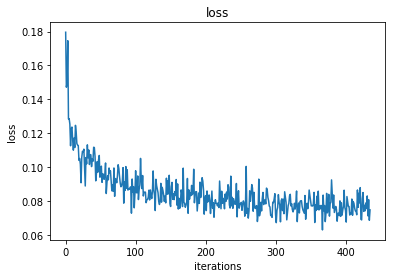

Epoch: 17/20... Training loss: 0.0703
Epoch: 17/20... Training loss: 0.0688
Epoch: 17/20... Training loss: 0.0794
Epoch: 17/20... Training loss: 0.0763
Epoch: 17/20... Training loss: 0.0704
Epoch: 17/20... Training loss: 0.0900
Epoch: 17/20... Training loss: 0.0726
Epoch: 17/20... Training loss: 0.0737
Epoch: 17/20... Training loss: 0.0705
Epoch: 17/20... Training loss: 0.0708
Epoch: 17/20... Training loss: 0.0744
Epoch: 17/20... Training loss: 0.0872
Epoch: 17/20... Training loss: 0.0663
Epoch: 17/20... Training loss: 0.0809
Epoch: 17/20... Training loss: 0.0745
Epoch: 17/20... Training loss: 0.0783
Epoch: 17/20... Training loss: 0.0755
Epoch: 17/20... Training loss: 0.0816
Epoch: 17/20... Training loss: 0.0748
Epoch: 17/20... Training loss: 0.0789
Epoch: 17/20... Training loss: 0.0911
Epoch: 17/20... Training loss: 0.0737
Epoch: 17/20... Training loss: 0.0775
Epoch: 17/20... Training loss: 0.0807
Epoch: 17/20... Training loss: 0.0788
Epoch: 17/20... Training loss: 0.0689
Epoch: 17/20

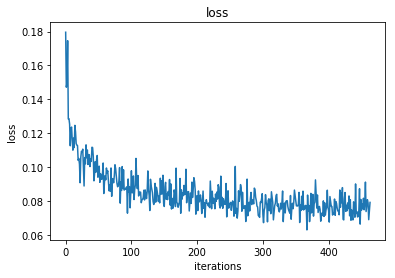

Epoch: 18/20... Training loss: 0.0735
Epoch: 18/20... Training loss: 0.0848
Epoch: 18/20... Training loss: 0.0763
Epoch: 18/20... Training loss: 0.0809
Epoch: 18/20... Training loss: 0.0861
Epoch: 18/20... Training loss: 0.0851
Epoch: 18/20... Training loss: 0.0818
Epoch: 18/20... Training loss: 0.0678
Epoch: 18/20... Training loss: 0.0746
Epoch: 18/20... Training loss: 0.0772
Epoch: 18/20... Training loss: 0.0702
Epoch: 18/20... Training loss: 0.0794
Epoch: 18/20... Training loss: 0.0737
Epoch: 18/20... Training loss: 0.0753
Epoch: 18/20... Training loss: 0.0791
Epoch: 18/20... Training loss: 0.0747
Epoch: 18/20... Training loss: 0.0674
Epoch: 18/20... Training loss: 0.0730
Epoch: 18/20... Training loss: 0.0806
Epoch: 18/20... Training loss: 0.0724
Epoch: 18/20... Training loss: 0.0744
Epoch: 18/20... Training loss: 0.0669
Epoch: 18/20... Training loss: 0.0736
Epoch: 18/20... Training loss: 0.0750
Epoch: 18/20... Training loss: 0.0732
Epoch: 18/20... Training loss: 0.0748
Epoch: 18/20

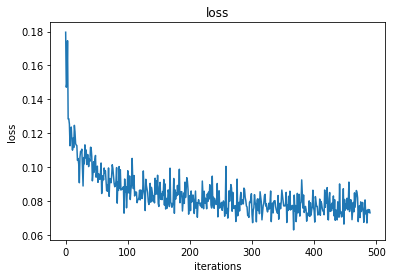

Epoch: 19/20... Training loss: 0.0718
Epoch: 19/20... Training loss: 0.0711
Epoch: 19/20... Training loss: 0.0871
Epoch: 19/20... Training loss: 0.0777
Epoch: 19/20... Training loss: 0.0705
Epoch: 19/20... Training loss: 0.0814
Epoch: 19/20... Training loss: 0.0748
Epoch: 19/20... Training loss: 0.0759
Epoch: 19/20... Training loss: 0.0746
Epoch: 19/20... Training loss: 0.0707
Epoch: 19/20... Training loss: 0.0796
Epoch: 19/20... Training loss: 0.0756
Epoch: 19/20... Training loss: 0.0797
Epoch: 19/20... Training loss: 0.0765
Epoch: 19/20... Training loss: 0.0834
Epoch: 19/20... Training loss: 0.0828
Epoch: 19/20... Training loss: 0.0734
Epoch: 19/20... Training loss: 0.0714
Epoch: 19/20... Training loss: 0.0906
Epoch: 19/20... Training loss: 0.0731
Epoch: 19/20... Training loss: 0.0756
Epoch: 19/20... Training loss: 0.0711
Epoch: 19/20... Training loss: 0.0759
Epoch: 19/20... Training loss: 0.0742
Epoch: 19/20... Training loss: 0.0717
Epoch: 19/20... Training loss: 0.0743
Epoch: 19/20

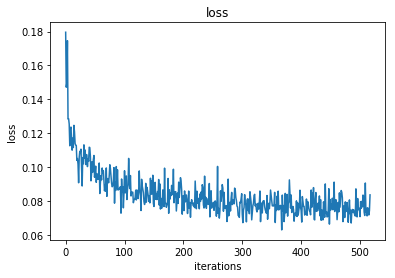

Epoch: 20/20... Training loss: 0.0658
Epoch: 20/20... Training loss: 0.0772
Epoch: 20/20... Training loss: 0.0822
Epoch: 20/20... Training loss: 0.0719
Epoch: 20/20... Training loss: 0.0738
Epoch: 20/20... Training loss: 0.0747
Epoch: 20/20... Training loss: 0.0746
Epoch: 20/20... Training loss: 0.0709
Epoch: 20/20... Training loss: 0.0742
Epoch: 20/20... Training loss: 0.0758
Epoch: 20/20... Training loss: 0.0750
Epoch: 20/20... Training loss: 0.0685
Epoch: 20/20... Training loss: 0.0736
Epoch: 20/20... Training loss: 0.0941
Epoch: 20/20... Training loss: 0.0678
Epoch: 20/20... Training loss: 0.0725
Epoch: 20/20... Training loss: 0.0664
Epoch: 20/20... Training loss: 0.0699
Epoch: 20/20... Training loss: 0.0822
Epoch: 20/20... Training loss: 0.0750
Epoch: 20/20... Training loss: 0.0790
Epoch: 20/20... Training loss: 0.0856
Epoch: 20/20... Training loss: 0.0827
Epoch: 20/20... Training loss: 0.0697
Epoch: 20/20... Training loss: 0.0813
Epoch: 20/20... Training loss: 0.0736
Epoch: 20/20

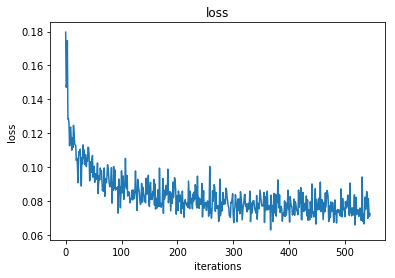

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 20
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
losses = []

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)
        
        '''
        print(np.min(batch[0]), np.max(batch[0]), "BF")
        plt.imshow(batch[0] / 255)
        plt.show()
        
        batch = normalize(batch)
        batch_labels = normalize(batch_labels)
        
        print(batch[0].shape, batch_labels[0].shape)
        print(np.min(batch[0]), np.max(batch[0]))
        
        plt.imshow(denormalize(batch[0]) / 255)
        plt.show()
        
        plt.imshow(denormalize(batch_labels[0]) / 255)
        plt.show()
        '''

        f_dict = {inputs_: batch, targets_: batch_labels, pose_:pose_labels}
        fetches = [train_op, loss_op]
        _, loss = sess.run(fetches, feed_dict=f_dict)
        if step % 100 == 0:
            losses.append(loss)
            print("Epoch: {}/{}...".format(epoch+1, epochs),
            "Training loss: {:.4f}".format(loss))
    plt.plot(losses)
    plt.title('loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

In [37]:

var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(var_list)
saver.save(sess, 'model/deep_encoder_pose_car')

'model/deep_encoder_pose_car'

In [38]:
d_pairs = test_pairs[5 * batch_size : 6 * batch_size]
test_batch, test_labels, test_pose = get_batch_data(d_pairs, False)
#d_pairs = train_pairs[5 * batch_size : 6 * batch_size]
#test_batch, test_labels, test_pose = get_batch_data(d_pairs, True)

In [39]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([res], feed_dict = feed_dict)

In [40]:
j = 20
op = denormalize(op[0])

In [41]:
#op = op.astype(np.uint8)
print(np.min(op), np.max(op))
#print(np.where(op < -0.00001 ))

#print(op[0][0][59])

0.018163 255.0


In [42]:
op = np.where(op < 0.0,0.0, op)

In [43]:
print(np.min(op), np.max(op))

0.018163 255.0


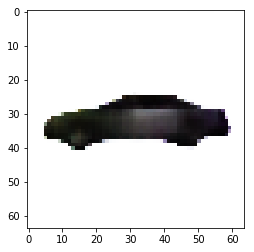

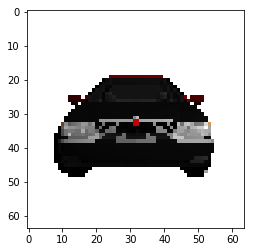

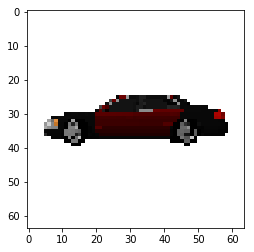

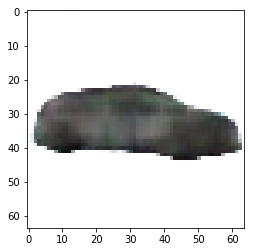

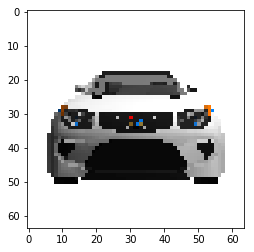

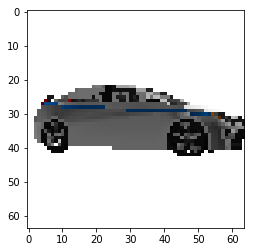

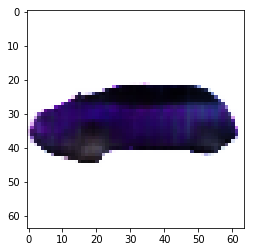

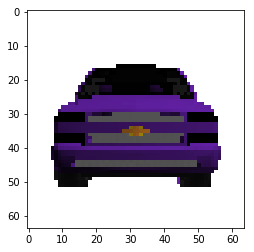

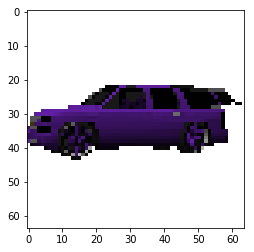

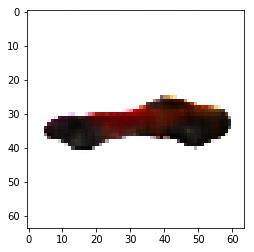

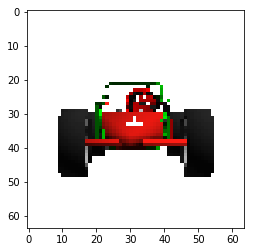

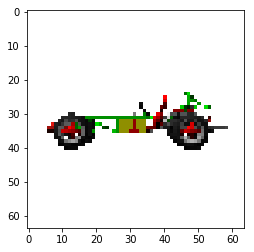

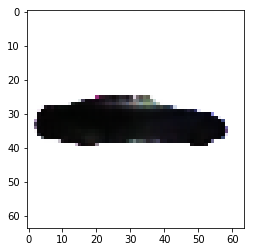

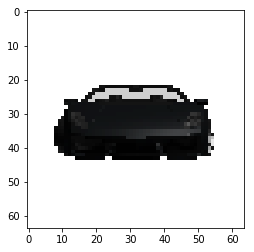

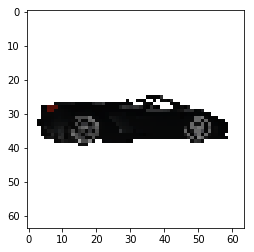

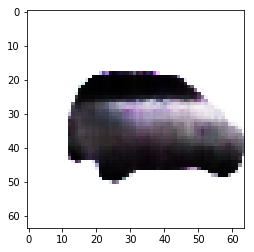

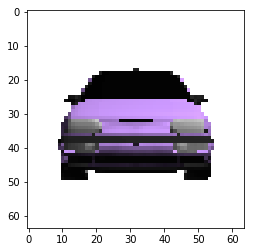

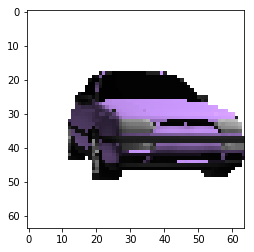

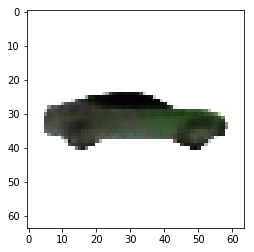

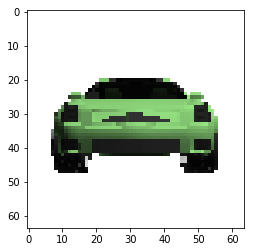

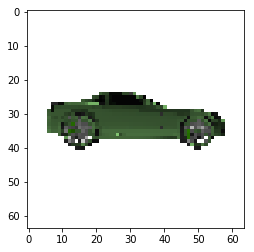

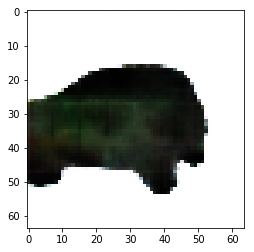

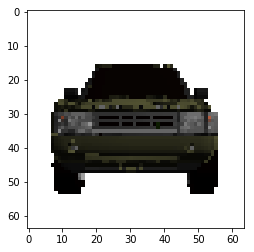

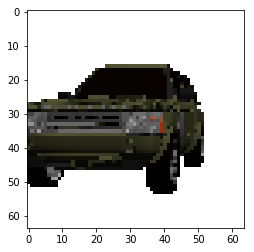

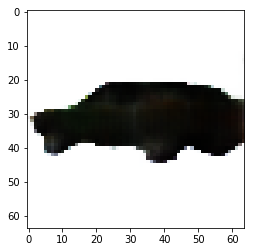

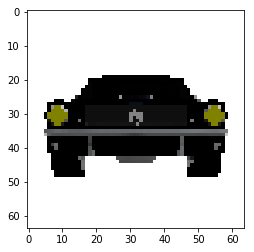

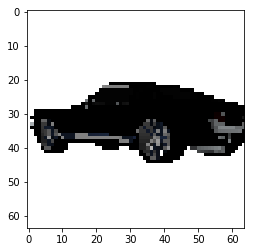

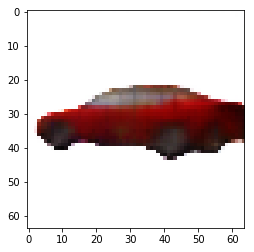

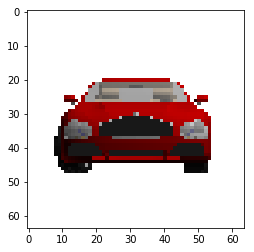

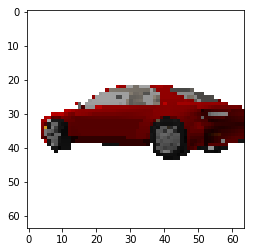

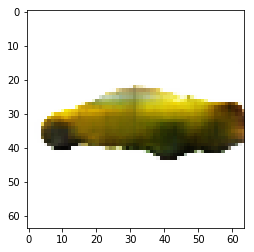

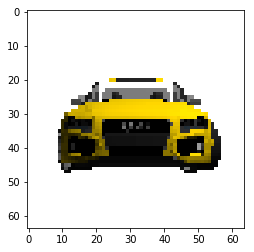

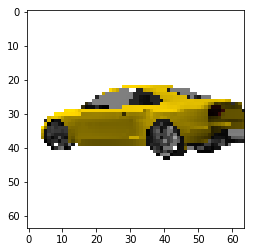

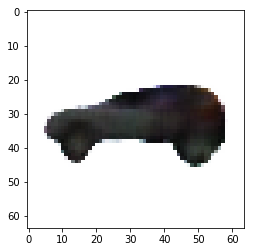

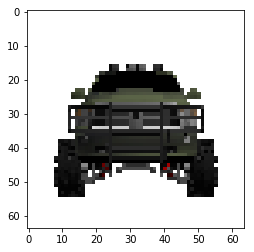

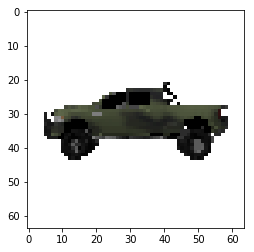

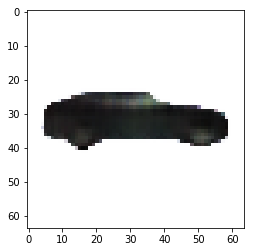

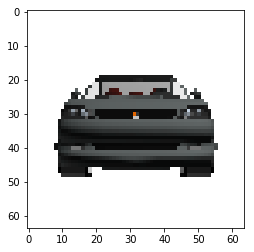

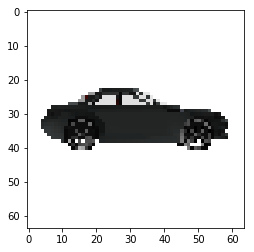

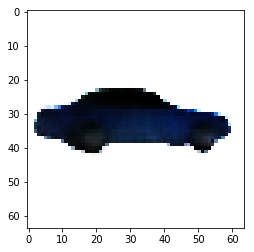

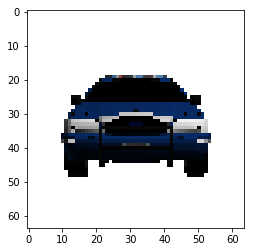

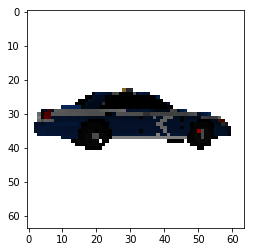

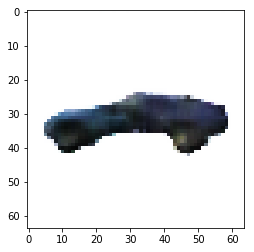

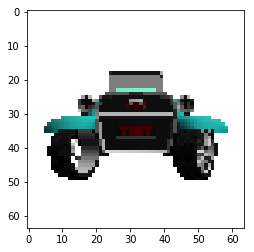

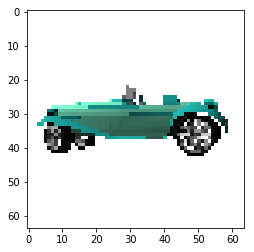

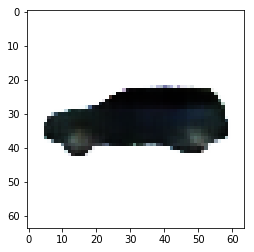

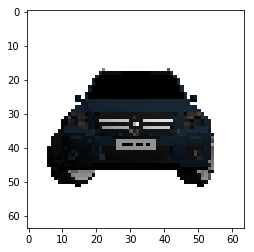

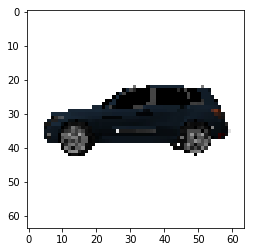

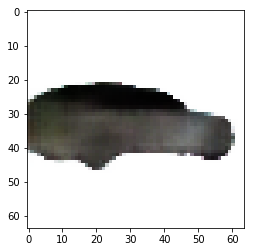

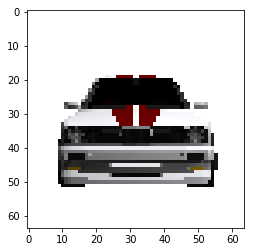

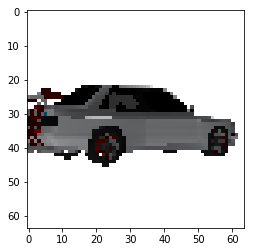

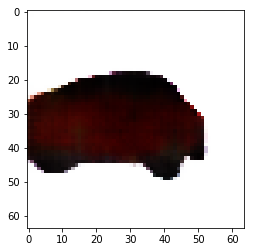

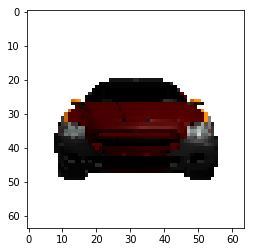

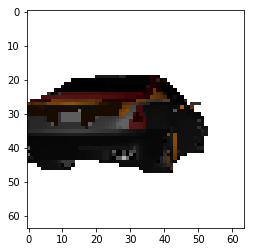

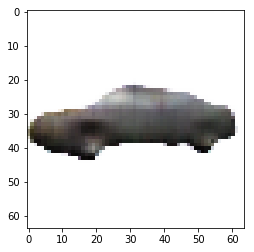

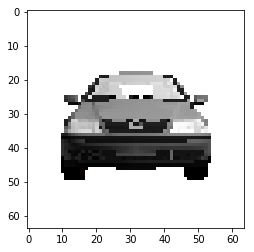

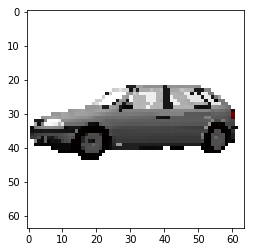

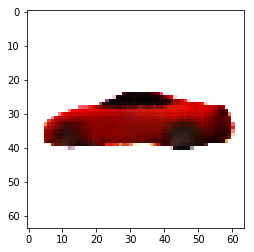

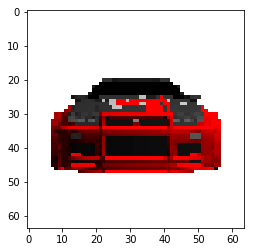

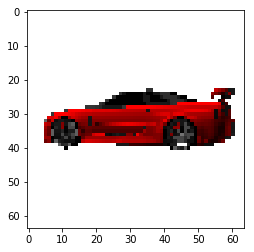

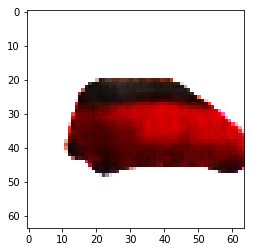

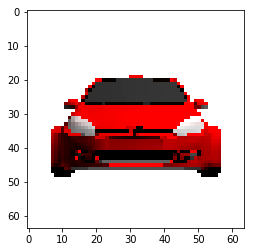

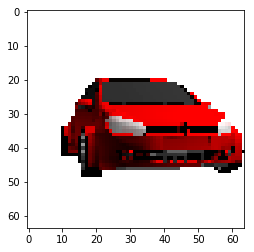

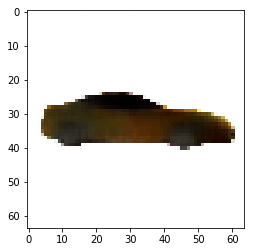

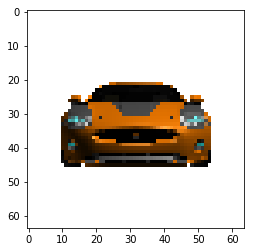

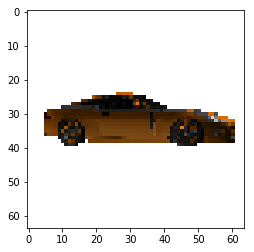

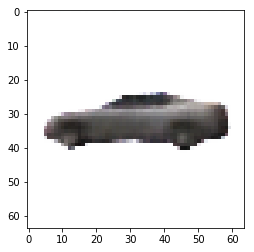

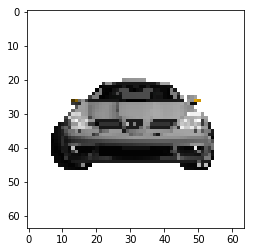

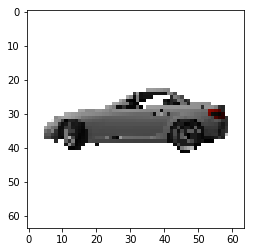

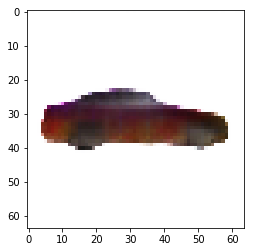

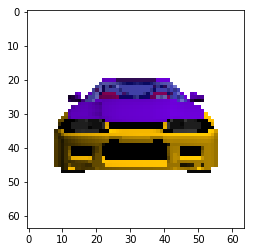

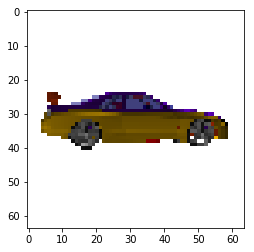

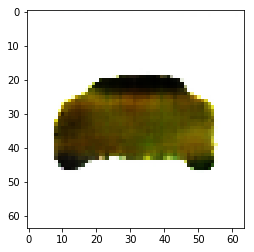

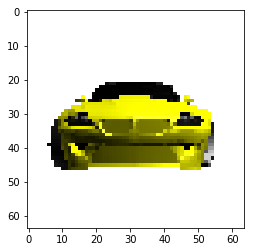

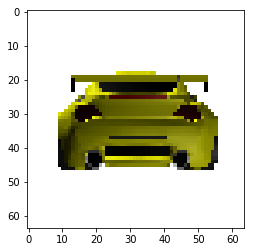

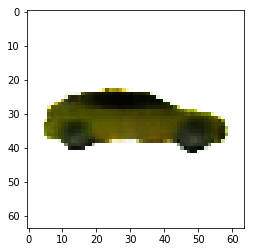

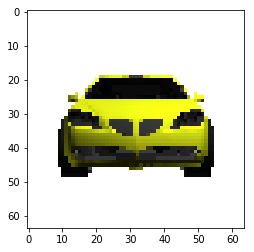

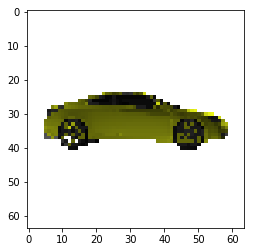

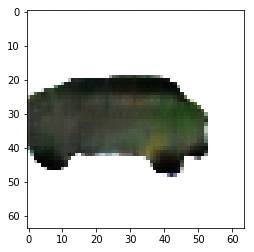

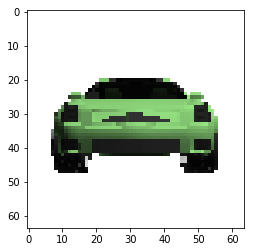

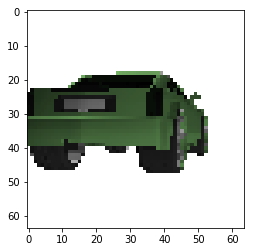

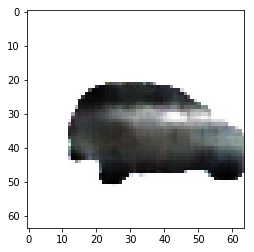

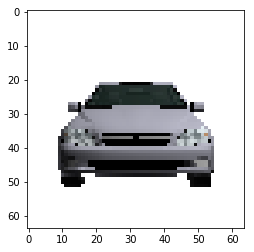

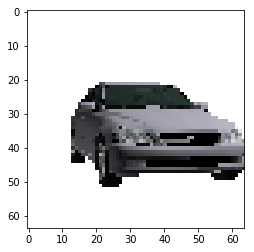

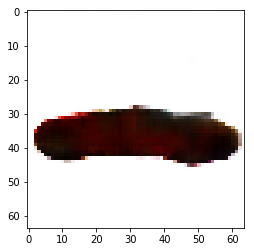

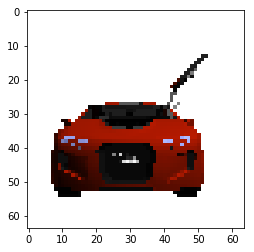

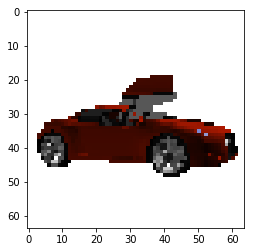

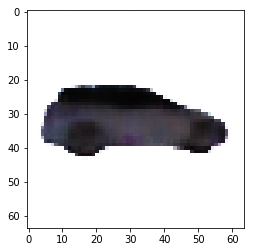

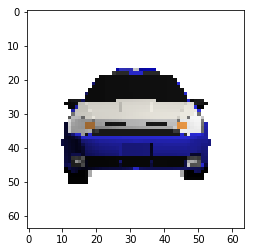

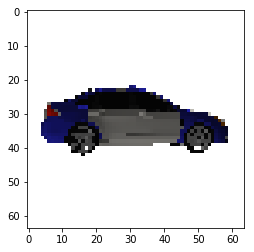

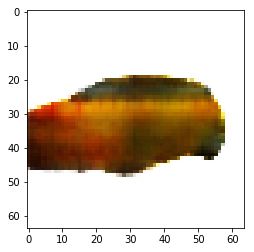

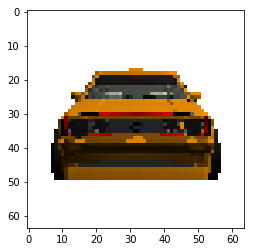

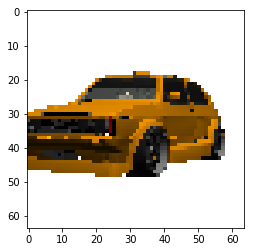

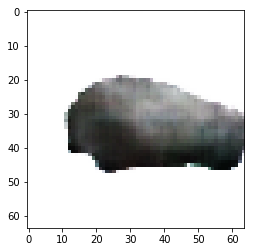

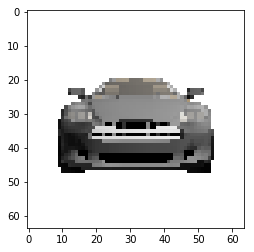

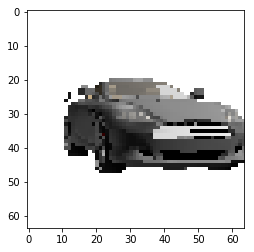

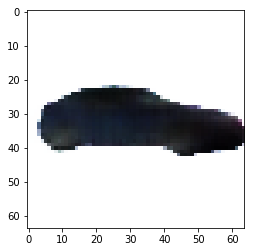

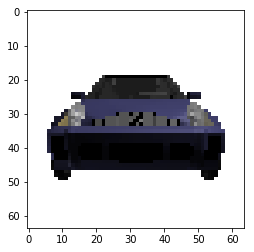

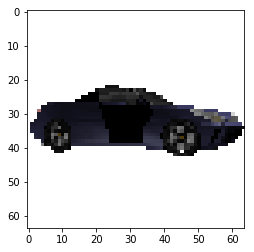

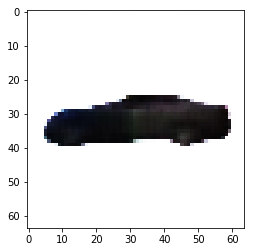

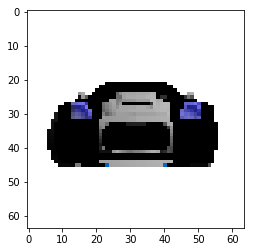

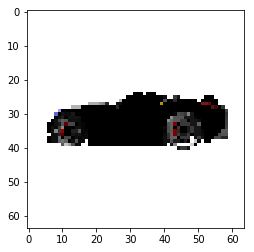

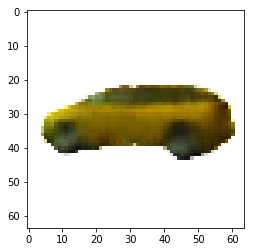

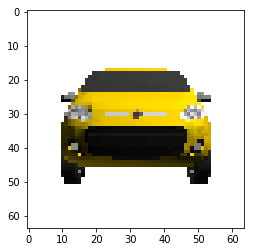

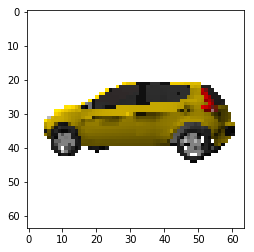

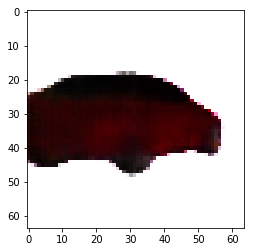

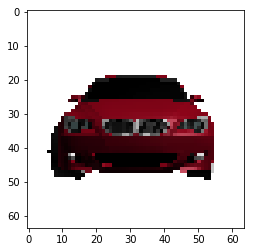

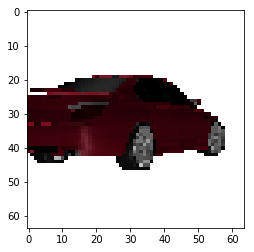

In [44]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()